In [1]:
# parameter
mass = {'body': 1.31844704893266, 
       'upperarm': 0.323696829552903, # LF2 of half cheetah model
       'forearm': 0.13341, # LF3 of half cheetah model
       'thigh': 0.323696605188412, #LB1 of hakf cheetah model
       'shank': 0.13341,
       'tail': 0}
# just to note for modelling in ROS width of main body is 0.2027
# Diameter of upperarm/forearm =0.09728
# Diameter of shank/ thigh  = 0.03861

length = {'body': 0.41557,
           'upperarm': 0.31036,# from Solidworks 
           'forearm': 0.26192,
           'thigh': 0.31036,
           'shank': 0.26192,
           'tail': 0}

dCOM = {'body': 0.41557/2, # Halfway
       'upperarm': 0.31036, #from link to link
       'forearm': 0.26192,
       'thigh': 0.31036,
       'shank': 0.26192,
       'tail': 0}

inertia = {'body': (1.0/12.0)*mass['body']*length['body']**2,
           'upperarm': (1.0/12.0)*mass['upperarm']*length['upperarm']**2,
           'forearm': (1.0/12.0)*mass['forearm']*length['forearm']**2,
           'thigh': (1.0/12.0)*mass['thigh']*length['thigh']**2,
           'shank': (1.0/12.0)*mass['shank']*length['shank']**2,
           'tail': (1.0/12.0)*mass['tail']*length['tail']**2,}

In [2]:
# DERIVE THE EOMs SYMBOLICALLY --------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np
import pickle as pickle

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,mf1,mf2,mh1,mh2,mt = sym.symbols(['m_{b}','m_{f1}','m_{f2}','m_{h1}','m_{h2}','m_{t}']) # mass
lb,lf1,lf2,lh1,lh2,lt = sym.symbols(['l_{b}','l_{f1}','l_{f2}','l_{h1}','l_{h2}','l_{t}']) # length
Inb,Inf1,Inf2,Inh1,Inh2,Int = sym.symbols(['I_{b}','I_{f1}','I_{f2}','I_{h1}','I_{h2}','I_{t}']) # mass

# generalized coordinates
sides = ['R']
x,y,thb,tht = sym.symbols(['x','y','\\theta_{b}','\\theta_{t}']) 
dx,dy,dthb,dtht = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{b}','\dot{\\theta}_{t}']) 
ddx,ddy,ddthb,ddtht = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{b}','\ddot{\\theta}_{t}']) 

thf1  = [sym.symbols('\\theta_{f1%s}'%sides[i]) for i in range(len(sides))]
thf2  = [sym.symbols('\\theta_{f2%s}'%sides[i]) for i in range(len(sides))]
thh1  = [sym.symbols('\\theta_{h1%s}'%sides[i]) for i in range(len(sides))]
thh2  = [sym.symbols('\\theta_{h2%s}'%sides[i]) for i in range(len(sides))]

dthf1  = [sym.symbols('\dot{\\theta}_{f1%s}'%sides[i]) for i in range(len(sides))]
dthf2  = [sym.symbols('\dot{\\theta}_{f2%s}'%sides[i]) for i in range(len(sides))]
dthh1  = [sym.symbols('\dot{\\theta}_{h1%s}'%sides[i]) for i in range(len(sides))]
dthh2  = [sym.symbols('\dot{\\theta}_{h2%s}'%sides[i]) for i in range(len(sides))]

ddthf1  = [sym.symbols('\ddot{\\theta}_{f1%s}'%sides[i]) for i in range(len(sides))]
ddthf2  = [sym.symbols('\ddot{\\theta}_{f2%s}'%sides[i]) for i in range(len(sides))]
ddthh1  = [sym.symbols('\ddot{\\theta}_{h1%s}'%sides[i]) for i in range(len(sides))]
ddthh2  = [sym.symbols('\ddot{\\theta}_{h2%s}'%sides[i]) for i in range(len(sides))]

q = sym.Matrix([x]+[y]+[thb]+[tht]+thf1+thf2+thh1+thh2)
dq = sym.Matrix([dx]+[dy]+[dthb]+[dtht]+dthf1+dthf2+dthh1+dthh2)
ddq = sym.Matrix([ddx]+[ddy]+[ddthb]+[ddtht]+ddthf1+ddthf2+ddthh1+ddthh2)

# rotation matrix
def get_R(th_in):    
    R = sym.Matrix([[sym.cos(th_in),-sym.sin(th_in)],
                    [sym.sin(th_in),sym.cos(th_in)]])
        
    return R

# positions

# body
p_b = sym.Matrix([[x],[y],[thb]])
J_b = p_b.jacobian(q)
v_b = J_b*dq

R_b = get_R(thb)

p_shoulder = sym.Matrix([[x],[y]]) + R_b*sym.Matrix([[lb*dCOM['body']],[0]])
p_hip = sym.Matrix([[x],[y]]) + R_b*sym.Matrix([[-lb*(1-dCOM['body'])],[0]])

# tail
R_t = get_R(tht)
p_t = sym.Matrix([sym.Matrix([[x],[y]]) + R_t*sym.Matrix([[-tht],[0]]),[tht]])
J_t = p_t.jacobian(q)
v_t = J_t*dq

# legs
p_lf1 = []
p_lf2 = []
p_lh1 = []
p_lh2 = []

J_lf1 = []
J_lf2 = []
J_lh1 = []
J_lh2 = []

v_lf1 = []
v_lf2 = []
v_lh1 = []
v_lh2 = []

p_elbow = []
p_knee = []

p_footf = []
p_footh = []
v_footf = []
v_footh = []

for i in range(len(sides)):
    # foreleg
    R_lf1 = get_R(thf1[i])
    p_lf1.append(sym.Matrix([p_shoulder + R_lf1*sym.Matrix([[0],[-dCOM['upperarm']*lf1]]),[thf1[i]]]))
    J_lf1.append(p_lf1[i].jacobian(q))
    v_lf1.append(J_lf1[i]*dq)
    
    p_elbow.append(p_shoulder + R_lf1*sym.Matrix([[0],[-lf1]])) 
    
    R_lf2 = get_R(thf2[i])
    p_lf2.append(sym.Matrix([p_elbow[i] + R_lf2*sym.Matrix([[0],[-dCOM['forearm']*lf2]]),[thf2[i]]]))
    J_lf2.append(p_lf2[i].jacobian(q))
    v_lf2.append(J_lf2[i]*dq)
    
    p_footf.append(sym.Matrix([p_elbow[i] + R_lf2*sym.Matrix([[0],[-lf2]])]))
    v_footf.append(p_footf[i].jacobian(q)*dq)
    
    # hindleg
    R_lh1 = get_R(thh1[i])
    p_lh1.append(sym.Matrix([p_hip + R_lh1*sym.Matrix([[0],[-dCOM['thigh']*lh1]]),[thh1[i]]]))
    J_lh1.append(p_lh1[i].jacobian(q))
    v_lh1.append(J_lh1[i]*dq)
    
    p_knee.append(p_hip + R_lh1*sym.Matrix([[0],[-lh1]]))
    
    R_lh2 = get_R(thh2[i])
    p_lh2.append(sym.Matrix([p_knee[i] + R_lh2*sym.Matrix([[0],[-dCOM['shank']*lh2]]),[thh2[i]]]))
    J_lh2.append(p_lh2[i].jacobian(q))
    v_lh2.append(J_lh2[i]*dq)
    
    p_footh.append(sym.Matrix([p_knee[i] + R_lh2*sym.Matrix([[0],[-lh2]])]))
    v_footh.append(p_footh[i].jacobian(q)*dq)
    
# STEP 2: Energy --------------------------------------------------------------------------------------------------------
# mass matrices for each link
Mb = sym.Matrix([[mb,0,0],[0,mb,0],[0,0,Inb]])
Mt = sym.Matrix([[mt,0,0],[0,mt,0],[0,0,Int]])
Mf1 = sym.Matrix([[mf1,0,0],[0,mf1,0],[0,0,Inf1]])
Mf2 = sym.Matrix([[mf2,0,0],[0,mf2,0],[0,0,Inf2]])
Mh1 = sym.Matrix([[mh1,0,0],[0,mh1,0],[0,0,Inh1]])
Mh2 = sym.Matrix([[mh2,0,0],[0,mh2,0],[0,0,Inh2]])

T = 0.5*v_b.transpose()*Mb*v_b + 0.5*v_t.transpose()*Mt*v_t
V = mb*g*p_b[1] + mt*g*p_t[1]

for i in range(len(sides)):
    T += 0.5*v_lf1[i].transpose()*Mf1*v_lf1[i] +\
    0.5*v_lf2[i].transpose()*Mf2*v_lf2[i] +\
    0.5*v_lh1[i].transpose()*Mh1*v_lh1[i] +\
    0.5*v_lh2[i].transpose()*Mh2*v_lh2[i]
    
    V += mf1*g*p_lf1[i][1] +\
    mf2*g*p_lf2[i][1] +\
    mh1*g*p_lh1[i][1] +\
    mh2*g*p_lh2[i][1]
    
# STEP 4: partials of T and V ----------------------------------------------------------------------------------------------
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces -----------------------------------------------------------------------------------------------

# forces
taut = sym.symbols('\\tau_{t}')
tauf1  = [sym.symbols('\\tau_{f1%s}'%sides[i]) for i in range(len(sides))]
tauf2  = [sym.symbols('\\tau_{f2%s}'%sides[i]) for i in range(len(sides))]
tauh1  = [sym.symbols('\\tau_{h1%s}'%sides[i]) for i in range(len(sides))]
tauh2  = [sym.symbols('\\tau_{h2%s}'%sides[i]) for i in range(len(sides))]

Gxf  = [sym.symbols('G_{xf%s}'%sides[i]) for i in range(len(sides))]
Gyf  = [sym.symbols('G_{yf%s}'%sides[i]) for i in range(len(sides))]
Gxh  = [sym.symbols('G_{xh%s}'%sides[i]) for i in range(len(sides))]
Gyh  = [sym.symbols('G_{yh%s}'%sides[i]) for i in range(len(sides))]

# joints -------------------------------------------------

# tail
taut_b = sym.Matrix([[0],[0],[-taut]])
taut_t = sym.Matrix([[0],[0],[taut]])
tau_Q = J_b.transpose()*taut_b + J_t.transpose()*taut_t

for i in range(len(sides)):
    # shoulder
    tauf1_b = sym.Matrix([[0],[0],[-tauf1[i]]])
    tauf1_f1 = sym.Matrix([[0],[0],[tauf1[i]]])
    tau_Q += J_b.transpose()*tauf1_b + J_lf1[i].transpose()*tauf1_f1
    
    # elbow
    tauf2_f1 = sym.Matrix([[0],[0],[-tauf2[i]]])
    tauf2_f2 = sym.Matrix([[0],[0],[tauf2[i]]])
    tau_Q += J_lf1[i].transpose()*tauf2_f1 + J_lf2[i].transpose()*tauf2_f2
    
    # hip
    tauh1_b = sym.Matrix([[0],[0],[-tauh1[i]]])
    tauh1_h1 = sym.Matrix([[0],[0],[tauh1[i]]])
    tau_Q += J_b.transpose()*tauh1_b + J_lh1[i].transpose()*tauh1_h1
    
    # knee
    tauh2_h1 = sym.Matrix([[0],[0],[-tauh2[i]]])
    tauh2_h2 = sym.Matrix([[0],[0],[tauh2[i]]])
    tau_Q += J_lh1[i].transpose()*tauh2_h1 + J_lh2[i].transpose()*tauh2_h2

# GRF -------------------------------------------------------------
GRF_Q = sym.zeros(q.shape[0],q.shape[1])
for i in range(len(sides)):
    R_lf2 = get_R(thf2[i])
    GRF_r = R_lf2*sym.Matrix([[0],[-(1-dCOM['forearm'])*lf2]])
    GRF_th = GRF_r[0]*Gyf[i] - GRF_r[1]*Gxf[i]
    GRF_Q += J_lf2[i].transpose()*sym.Matrix([[Gxf[i]],[Gyf[i]],[GRF_th]])
    
    R_lh2 = get_R(thh2[i])
    GRF_r = R_lh2*sym.Matrix([[0],[-(1-dCOM['shank'])*lh2]])
    GRF_th = GRF_r[0]*Gyh[i] - GRF_r[1]*Gxh[i]
    GRF_Q += J_lh2[i].transpose()*sym.Matrix([[Gxh[i]],[Gyh[i]],[GRF_th]])
    
Q = tau_Q + GRF_Q

#AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q 


In [3]:
# # LAMBDIFY ------------------------------------------------------------------------------------------------------------------    
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,
            mb,mf1,mf2,mh1,mh2,mt,
            lb,lf1,lf2,lh1,lh2,lt,
            Inb,Inf1,Inf2,Inh1,Inh2,Int,
            x,y,thb,tht]+thf1+thf2+thh1+thh2+\
            [dx,dy,dthb,dtht]+dthf1+dthf2+dthh1+dthh2+\
            [ddx,ddy,ddthb,ddtht]+ddthf1+ddthf2+ddthh1+ddthh2+\
            [taut]+tauf1+tauf2+tauh1+tauh2+\
            Gxf+Gxh+Gyf+Gyh


lamb_EOM = {}
lamb_EOM0 = {}
DOFs = [('x','b'),
        ('y','b'),
        ('thb','b'),
        ('tht','b'),
        ('thf1','R'),
        ('thf2','R'),
        ('thh1','R'),
        ('thh2','R')]

for dof_i, dof in enumerate(DOFs):
    lamb_EOM.update({dof: sym.lambdify(sym_list,EOM[dof_i],modules = [func_map])})
    
lamb_pfoot = {}
lamb_vfoot = {}
for s_i, side in enumerate(['R']):
    for dof_i, dof in enumerate(['x','y']):
        lamb_pfoot.update({(dof,'f',side): sym.lambdify(sym_list,p_footf[s_i][dof_i],modules = [func_map])})
        lamb_vfoot.update({(dof,'f',side): sym.lambdify(sym_list,v_footf[s_i][dof_i],modules = [func_map])})
        lamb_pfoot.update({(dof,'h',side): sym.lambdify(sym_list,p_footh[s_i][dof_i],modules = [func_map])})
        lamb_vfoot.update({(dof,'h',side): sym.lambdify(sym_list,v_footh[s_i][dof_i],modules = [func_map])})

# Added this so I could prevent the joints from going through the floor
lamb_jointy = {}
for s_i, side in enumerate(['R']):
    lamb_jointy.update({('shoulder',side): sym.lambdify(sym_list,p_shoulder[1],modules = [func_map])})
    lamb_jointy.update({('elbow',side): sym.lambdify(sym_list,p_elbow[s_i][1],modules = [func_map])})
    lamb_jointy.update({('hip',side): sym.lambdify(sym_list,p_hip[1],modules = [func_map])})
    lamb_jointy.update({('knee',side): sym.lambdify(sym_list,p_knee[s_i][1],modules = [func_map])})

In [4]:
# Pyomo model
P = 1 # adapted this from code using a more advanced collocation method with multiple points per timestep. Don't worry about P.
DOFs = [('x','b'),
        ('y','b'),
        ('thb','b'),
        ('tht','b'),
        ('thf1','R'),
        ('thf2','R'),
        ('thh1','R'),
        ('thh2','R')]

WDOFs = ['x','y'] 
sides = ['R']
links = ['b','lf1','lf2','lh1','lh2','t']
joints = [('tail','b')]+[(j,s) for j in ['shoulder','elbow','hip','knee'] for s in sides]
contacts = [(c,s) for c in ['f','h'] for s in sides]

ground_constraints = ['contact','sliding_ps','sliding_ng']
signs = ['ps','ng']

def get_var_list(m,n):
    var_list = [m.g]+\
               [m.m[l] for l in links]+\
               [m.len[l] for l in links]+\
               [m.In[l] for l in links]+\
               [m.q[n,dof] for dof in DOFs]+\
               [m.dq[n,dof] for dof in DOFs]+\
               [m.ddq[n,dof] for dof in DOFs]+\
               [9.81*m.force_a[n,j] for j in joints]+\
               [9.81*m.GRF[n,c,dof] for dof in WDOFs for c in contacts]

    return var_list

def create_model(N,hm,mu):
    m = ConcreteModel()

    # SETS-----------------------------------------------------------------------------------------------------------------------

    m.N = RangeSet(N) # finite elements
    m.P = Set(initialize = [1]) # collocation points
    m.L = Set(initialize = links) # link types
    m.J = Set(initialize = joints, dimen=2) # joints
    m.DOF = Set(initialize = DOFs, dimen = 2) # generalized coordinates
    m.WDOF = Set(initialize = WDOFs) # world frame coordinates
    m.C = Set(initialize = contacts,dimen = 2) # ground contact points
    m.sgn = Set(initialize = signs) # sign set for positive and negative components
    m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-contact-related penalties
    
    # PARAMETERS-----------------------------------------------------------------------------------------------------------------

    m.g = Param(initialize = 9.81)

    def get_m(n, l):
        if l == 'b':
            return mass['body']
        if l == 'lf1':
            return mass['upperarm']
        if l == 'lf2':
            return mass['forearm']
        if l == 'lh1':
            return mass['thigh']
        if l == 'lh2':
            return mass['shank']
        if l == 't':
            return mass['tail']
    m.m = Param(m.L, initialize = get_m) # mass of links

    def get_len(n, l):
        if l == 'b':
            return length['body']
        if l == 'lf1':
            return length['upperarm']
        if l == 'lf2':
            return length['forearm']
        if l == 'lh1':
            return length['thigh']
        if l == 'lh2':
            return length['shank']
        if l == 't':
            return length['tail']
    m.len = Param(m.L, initialize = get_len) # length of links

    def calculate_In(m, l): 
        if l == 'b':
            return inertia['body']
        if l == 'lf1':
            return inertia['upperarm']
        if l == 'lf2':
            return inertia['forearm']
        if l == 'lh1':
            return inertia['thigh']
        if l == 'lh2':
            return inertia['shank']
        if l == 't':
            return inertia['tail']
    m.In = Param(m.L, initialize = calculate_In) # moment of inertia

    # VARIABLES -----------------------------------------------------------------------------------------------------------------

    # system coordinates
    m.q = Var(m.N, m.DOF) # position
    m.dq = Var(m.N, m.DOF) # velocity
    m.ddq = Var(m.N, m.DOF) # acceleration
    
    m.force_a = Var(m.N, m.J) # actuator forces

    m.GRF = Var(m.N, m.C, m.WDOF) # ground reaction forces

    # bound variables
    for n in range(1,N+1):
        m.q[n,('y','b')].setlb(0)
        m.q[n,('thb','b')].setlb(-np.pi/2)
        m.q[n,('thb','b')].setub(np.pi/2)
        for c in contacts:
            m.GRF[n,c,'y'].setlb(0)
            
    # TIME AND INTEGRATION ---------------------------------------------------------------------------------------------------

    # variable timestep
    m.hm = Param(initialize = hm, mutable = True) # master timestep
    m.h = Var(m.N, bounds = (0.8,1.0))
    
    # Integration constraints 
    def integrate_p(m,n,dof1,dof2):
        dof = (dof1,dof2)
        if n == 1: return Constraint.Skip
        return m.q[n,dof] == m.q[n-1,dof] + m.hm*m.h[n]*m.dq[n,dof]
    m.integrate_p = Constraint(m.N, m.DOF, rule = integrate_p)

    def integrate_v(m,n,dof1,dof2):
        dof = (dof1,dof2)
        if n == 1: return Constraint.Skip
        return m.dq[n,dof] == m.dq[n-1,dof] + m.hm*m.h[n]*m.ddq[n,dof]
    m.integrate_v = Constraint(m.N, m.DOF, rule = integrate_v)
    
    # EOM --------------------------------------------------------------------------------------------------------------------
    
    def dynamics(m,n,dof1,dof2):
        dof = (dof1,dof2)
        var_list = get_var_list(m,n)
        if n == 1: return Constraint.Skip
        return lamb_EOM[dof](*var_list) == 0
    m.dynamics = Constraint(m.N, m.DOF, rule = dynamics)

    # JOINT CONSTRAINTS ----------------------------------------------------------------------------------------------------------

    m.jointp = Var(m.N, m.J) # joint position, relative
    
    # I use absolute angles because it leads to simpler equations in 2D, but it means you need to calculate the relative 
    # angles so you can bound the ranges of motion.
    
    m.jointy = Var(m.N, m.J, bounds = (0,None)) # joint height

    def def_jointp(m,n,j1,j2):
        j = (j1,j2)
        if j1 == 'tail':
            return m.jointp[n,j] == m.q[n,'tht',j2] - m.q[n,'thb','b']
        if j1 == 'shoulder':
            return m.jointp[n,j] == m.q[n,'thf1',j2] - m.q[n,'thb','b']
        if j1 == 'elbow':
            return m.jointp[n,j] == m.q[n,'thf2',j2] - m.q[n,'thf1',j2]
        if j1 == 'hip':
            return m.jointp[n,j] == m.q[n,'thh1',j2] - m.q[n,'thb','b']
        if j1 == 'knee':
            return m.jointp[n,j] == m.q[n,'thh2',j2] - m.q[n,'thh1',j2]
    m.def_jointp = Constraint(m.N, m.J, rule = def_jointp)

    def def_jointy(m,n,j1,j2):
        j = (j1,j2)
        if j1 == 'tail':
            return m.jointy[n,j] == m.jointy[n,'hip','R']
        var_list = get_var_list(m,n)
        return m.jointy[n,j] == lamb_jointy[j](*var_list)
    m.def_jointy = Constraint(m.N, m.J, rule = def_jointy)
        
#     joint limits
# note Stacey's joints go clockwise
    for n in range(1,N+1):
        m.jointp[n,'tail','b'].setlb(-np.pi/2)
        m.jointp[n,'tail','b'].setub(np.pi)
        for s in sides:
            m.jointp[n,'shoulder',s].setlb(-np.pi*(4/9)) #changed
            m.jointp[n,'shoulder',s].setub(np.pi*(2/9))
            m.jointp[n,'elbow',s].setlb(np.pi*(1/9))
            m.jointp[n,'elbow',s].setub(np.pi*(83/90))
            m.jointp[n,'hip',s].setlb(-np.pi*(4/9))
            m.jointp[n,'hip',s].setub(np.pi*(2/9))
            m.jointp[n,'knee',s].setlb(np.pi*(1/9))
            m.jointp[n,'knee',s].setub(np.pi*(83/90))

    # GROUND MODEL -----------------------------------------------------------------------------------------------------------

    # ground parameters
    m.mu_k = Param(initialize = mu) # coefficient of kinetic friction
    
    # foot position and velocity -----------------------------------
    m.foot_height = Var(m.N, m.C, bounds = (0,None)) # foot position
    m.footv = Var(m.N, m.C) # foot velocity in x direction
    m.footv2 = Var(m.N, m.C, m.sgn, bounds = (0,None)) # foot velocity +ve and -ve parts
    
    
    def def_foot_height(m,n,c1,c2):
        c = (c1,c2)
        var_list = get_var_list(m,n)
        return m.foot_height[n,c] == lamb_pfoot[('y',c1,c2)](*var_list)
    m.def_foot_height = Constraint(m.N, m.C, rule = def_foot_height)    
    
    
    def def_footv(m,n,c1,c2):
        c = (c1,c2)
        if n == 1: return Constraint.Skip
        var_list = get_var_list(m,n)
        return m.footv[n,c] == lamb_vfoot[('x',c1,c2)](*var_list)
    m.def_footv = Constraint(m.N, m.C, rule = def_footv)
    
    def def_footv2(m,n,c1,c2):
        c = (c1,c2)
        if n == 1: return Constraint.Skip
        return m.footv[n,c] == m.footv2[n,c,'ps'] - m.footv2[n,c,'ng']
    m.def_footv2 = Constraint(m.N, m.C, rule = def_footv2)
    
    # friction -------------------------------------------------------------
    # the way I do friction here is a little different to the tutorials but they both work equally well
    m.alpha = Var(m.N, m.C, bounds = (0,1))
    
    def friction(m,n,c1,c2):
        c = (c1,c2)
        if n == 1: return Constraint.Skip
        return m.GRF[n,c,'x'] == (1 - 2*m.alpha[n,c])*m.mu_k*m.GRF[n,c,'y']
    m.friction = Constraint(m.N, m.C, rule = friction)
    
    # ground complementarity ------------------------------------------------------------------------------------------------
    m.ground_penalty = Var(m.N, m.C, m.ground_constraints, bounds = (0.0,None))

    def ground_complementarity(m,n,c1,c2,gc):
        c = (c1,c2)
        if n == 1: return Constraint.Skip
        
        if gc == 'contact':
            A = m.GRF[n,c,'y']
            if n < N:
                B = m.foot_height[n,c] + m.foot_height[n+1,c]
            else:
                B = m.foot_height[n,c]
                
        if gc == 'sliding_ps':
            A = 1 - m.alpha[n,c]
            B = m.footv2[n,c,'ps']
            
        if gc == 'sliding_ng':
            A = m.alpha[n,c]
            B = m.footv2[n,c,'ng']   
        
        return A*B <= m.ground_penalty[n,c,gc]
    m.ground_complementarity = Constraint(m.N, m.C, m.ground_constraints, rule = ground_complementarity)
     # m.force_a   
#     OBJECTIVES -----------------------------------------------------------------------------------------------------------
    def MinPenalty(m):
        return sum([m.ground_penalty[n,c,gc] for n in range(1,N+1) for c in contacts for gc in ground_constraints])
    m.MinPenalty = Objective(rule = MinPenalty)
    
    def Min_torque(m):
        return sum([m.force_a[n,j]**2 for n in range(1,N+1) for j in joints])
    m.Min_torque = Objective(rule = Min_torque)
    
    m.Min_torque.deactivate()

    
    return m

In [6]:
def init_opt(): # initializes solver
    #opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Stacey/CoinIpopt/build/bin/ipopt.exe')
    #opt.options["linear_solver"] = 'ma97'
    opt = SolverFactory('ipopt')
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = 30000 # maximum number of iterations
    opt.options["max_cpu_time"] = 3600 # maximum cpu time in seconds
    opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt

In [7]:
def jump3(m):
    for dof in DOFs:
        m.dq[1,dof].fix(0)
        m.q[1,dof].fix(0)
    m.q[1,'y','b'].unfix()
    for c in contacts:
        m.foot_height[N,c].fix(0)
        
    m.dq[1,'y','b'].fix(1.4)
    m.dq[1,'x','b'].fix(2)
    m.ddq[1,'x','b'].fix(1.4)
    m.dq[1,'thh1','R'].fix(1.4)
    m.dq[1,'thf1','R'].fix(1.4)
#     m.dq[1,'thh2','R'].fix(0)
#     m.dq[1,'thf2','R'].fix(0)
    #'thf2','R'
    return m


In [8]:
N = 30
hm = 0.02
mu = 0.5
m = create_model(N,hm,mu)


m = jump3(m)

opt = init_opt()
results = opt.solve(m,tee=True)

Ipopt 3.13.3: print_level=5
max_iter=30000
max_cpu_time=3600
Tol=1e-06
option_file_name=/tmp/tmprfjx8sep_ipopt.opt

Using option file "/tmp/tmprfjx8sep_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7600
Number of nonzeros in inequality constraint Jacobian.:      572
Number of nonzeros in Lagrangian Hessian.............:     3590

Total number of variables............................:     1757
                     variables with only lower b

  83r 2.8681507e+02 3.49e-01 6.03e+01  -4.2 1.25e+00  -0.7 2.31e-01 8.19e-02f  1
  84r 2.8689397e+02 3.49e-01 3.85e+01  -4.2 3.78e+00  -1.2 1.68e-01 3.16e-01f  1
  85r 2.8694813e+02 3.49e-01 2.74e+01  -4.2 1.43e+00  -0.7 6.41e-01 3.79e-01f  1
  86r 2.8701488e+02 3.49e-01 2.28e+01  -4.2 4.33e+00  -1.2 8.34e-02 1.36e-01f  1
  87r 2.8712460e+02 3.49e-01 4.72e-01  -4.2 1.61e+00  -0.8 6.75e-01 9.00e-01f  1
  88r 2.8746247e+02 3.49e-01 1.37e+00  -4.2 4.75e+00  -1.3 5.15e-01 6.32e-01f  1
  89r 2.8765580e+02 3.49e-01 5.14e+00  -4.2 1.78e+00  -0.8 2.16e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 2.8800609e+02 3.49e-01 7.13e-01  -4.2 5.24e+00  -1.3 7.99e-01 6.54e-01f  1
  91r 2.8856136e+02 3.49e-01 2.89e+00  -4.2 1.47e+01  -1.8 4.60e-01 3.83e-01f  1
  92r 2.8861216e+02 3.49e-01 2.50e-01  -4.2 7.22e-01  -0.5 1.00e+00 1.00e+00f  1
  93r 2.8869849e+02 3.49e-01 9.47e-01  -4.2 2.14e+00  -0.9 4.77e-01 6.87e-01f  1
  94r 2.8875668e+02 3.49e-01

 221r 2.9021140e+02 3.49e-01 5.81e-03  -6.3 3.71e-02    -  1.00e+00 1.00e+00h  1
 222r 2.9018767e+02 3.49e-01 6.25e-07  -6.3 2.65e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 222

                                   (scaled)                 (unscaled)
Objective...............:   2.9018230608563334e+02    2.9018230608563334e+02
Dual infeasibility......:   9.9999947030169112e-01    9.9999947030169112e-01
Constraint violation....:   3.4906584094747789e-01    3.4906584094747789e-01
Complementarity.........:   5.4901321535141537e-07    5.4901321535141537e-07
Overall NLP error.......:   9.9999947030169112e-01    9.9999947030169112e-01


Number of objective function evaluations             = 249
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 249
Number of inequality constraint evaluations          = 249
Number of equality constraint Jacobian evaluations   = 231
Number of inequality constraint Jacobian evaluations =

In [9]:


#positions
x_out = [m.q[n,'x','b'].value for n in range(1,N+1)]
y_out = [m.q[n,'y','b'].value for n in range(1,N+1)]
thb_out = [m.q[n,'thb','b'].value for n in range(1,N+1)]
thf1_out = [m.q[n,'thf1','R'].value for n in range(1,N+1)]
thf2_out = [m.q[n,'thf2','R'].value for n in range(1,N+1)]
thh1_out = [m.q[n,'thh1','R'].value for n in range(1,N+1)]
thh2_out = [m.q[n,'thh2','R'].value for n in range(1,N+1)]

angle_data = [thf1_out,thf2_out,thh1_out,thh2_out]

#velocity
dx_out = [m.dq[n,'x','b'].value for n in range(1,N+1)]
dy_out = [m.dq[n,'y','b'].value for n in range(1,N+1)]
dthb_out = [m.dq[n,'thb','b'].value for n in range(1,N+1)]
dtht_out = [m.dq[n,'tht','b'].value for n in range(1,N+1)]
dthf1_out = [m.dq[n,'thf1','R'].value for n in range(1,N+1)]
dthf2_out = [m.dq[n,'thf2','R'].value for n in range(1,N+1)]
dthh1_out = [m.dq[n,'thh1','R'].value for n in range(1,N+1)]
dthh2_out = [m.dq[n,'thh2','R'].value for n in range(1,N+1)]

#acceleration
ddx_out = [m.ddq[n,'x','b'].value for n in range(1,N+1)]
ddy_out = [m.ddq[n,'y','b'].value for n in range(1,N+1)]
ddthb_out = [m.ddq[n,'thb','b'].value for n in range(1,N+1)]
ddtht_out = [m.ddq[n,'tht','b'].value for n in range(1,N+1)]
ddthf1_out = [m.ddq[n,'thf1','R'].value for n in range(1,N+1)]
ddthf2_out = [m.ddq[n,'thf2','R'].value for n in range(1,N+1)]
ddthh1_out = [m.ddq[n,'thh1','R'].value for n in range(1,N+1)]
ddthh2_out = [m.ddq[n,'thh2','R'].value for n in range(1,N+1)]


meas_angles = zip(thf1_out,thf2_out,thh1_out,thh2_out)
import csv

# header =['x','y','thb','tht','thf1','thf2','thh1','thh2',
#         'dx','dy','dthb','dtht','dthf1','dthf2','dthh1','dthh2',
#         'ddx','ddy','ddthb','ddtht','ddthf1','ddthf2','ddthh1','ddthh2',]

header2 = ['thf1','thf2','thh1','thh2']

with open('angles_pyomo.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f, delimiter='\t')    
    writer.writerow(header2)    
    writer.writerows(meas_angles )

with open('angles_pyomo.txt', 'w') as fp:
    fp.write('angle_data')



In [10]:
import pickle

# class angle_data:
#     N = 30
#     thb_out = [m.q[n,'thb','b'].value for n in range(1,N+1)]
#     thf1_out = [m.q[n,'thf1','R'].value for n in range(1,N+1)]
#     thf2_out = [m.q[n,'thf2','R'].value for n in range(1,N+1)]
#     thh1_out = [m.q[n,'thh1','R'].value for n in range(1,N+1)]
#     thh2_out = [m.q[n,'thh2','R'].value for n in range(1,N+1)]

N = 30
#thb_out = [m.q[n,'thb','b'].value for n in range(1,N+1)]
thf1_out = [m.q[n,'thf1','R'].value for n in range(1,N+1)]
thf2_out = [m.q[n,'thf2','R'].value for n in range(1,N+1)]
thh1_out = [m.q[n,'thh1','R'].value for n in range(1,N+1)]
thh2_out = [m.q[n,'thh2','R'].value for n in range(1,N+1)]

#velocity
dx_out = [m.dq[n,'x','b'].value for n in range(1,N+1)]
dy_out = [m.dq[n,'y','b'].value for n in range(1,N+1)]
dthb_out = [m.dq[n,'thb','b'].value for n in range(1,N+1)]
dtht_out = [m.dq[n,'tht','b'].value for n in range(1,N+1)]
dthf1_out = [m.dq[n,'thf1','R'].value for n in range(1,N+1)]
dthf2_out = [m.dq[n,'thf2','R'].value for n in range(1,N+1)]
dthh1_out = [m.dq[n,'thh1','R'].value for n in range(1,N+1)]
dthh2_out = [m.dq[n,'thh2','R'].value for n in range(1,N+1)]


angle_data =[thf1_out,thf2_out,thh1_out,thh2_out]
velocity_data =[dthf1_out,dthf2_out,dthh1_out,dthh2_out]

#angle_data_obj = angle_data()
#my_pickkle = pickle.dump(angle_data_obj)
file = open('final_angles_data_pyomo', 'wb')
pickle.dump(angle_data,file)
file.close()

file = open('final_angles_velocity', 'wb')
pickle.dump(velocity_data,file)
file.close()

In [11]:
m.MinPenalty.deactivate()

for n in range (1,N+1):
    
    for c in contacts:
        #
        for gc in ground_constraints:
            m.ground_penalty[n,c,gc].setub(1e-4)
m.Min_torque.activate()

results = opt.solve(m,tee=True)

Ipopt 3.13.3: print_level=5
max_iter=30000
max_cpu_time=3600
Tol=1e-06
option_file_name=/tmp/tmpc0nnais3_ipopt.opt

Using option file "/tmp/tmpc0nnais3_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7600
Number of nonzeros in inequality constraint Jacobian.:      572
Number of nonzeros in Lagrangian Hessian.............:     3740

Total number of variables............................:     1756
                     variables with only lower b

  87r 3.2838517e+00 3.49e-01 5.87e+02  -4.2 4.16e+01  -2.4 1.92e-02 2.18e-02f  1
  88r 3.2838441e+00 3.49e-01 6.32e+02  -4.2 9.31e-01  -0.2 1.72e-02 7.65e-05h  1
  89r 3.2901953e+00 3.49e-01 5.21e+02  -4.2 8.48e-01  -0.7 2.46e-01 4.29e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 3.2958165e+00 3.49e-01 5.29e+02  -4.2 2.10e+00  -1.1 5.99e-02 1.45e-02f  1
  91r 4.3162387e+00 3.49e-01 1.08e+02  -4.2 6.56e+00  -1.6 1.00e+00 7.60e-01f  1
  92r 5.0009992e+00 3.49e-01 8.71e+01  -4.2 1.72e+01  -2.1 1.69e-01 1.81e-01f  1
  93r 5.0060665e+00 3.49e-01 1.19e+02  -4.2 7.50e+00  -0.8 3.86e-05 1.96e-03h  1
  94r 5.0075435e+00 3.49e-01 1.12e+02  -4.2 2.54e-01  -0.3 5.17e-02 5.25e-02f  1
  95r 5.0099032e+00 3.49e-01 6.58e+01  -4.2 1.33e+00  -0.8 6.39e-02 7.01e-03f  1
  96r 5.0103522e+00 3.49e-01 1.07e+02  -4.2 3.03e-01  -0.4 1.10e-01 9.35e-03f  1
  97r 5.0150992e+00 3.49e-01 8.17e+01  -4.2 1.32e+00  -0.9 3.43e-02 1.45e-02h  1
  98r 5.0174112e+00 3.49e-01

 225r 1.3984564e+01 4.47e-01 8.43e+01  -6.3 3.08e+02  -4.0 3.76e-03 8.83e-04f  1
 226r 1.4060010e+01 4.41e-01 8.48e+01  -6.3 2.69e+01  -2.7 9.08e-02 1.71e-02f  1
 227r 1.4060586e+01 4.41e-01 1.03e+02  -6.3 7.24e+01  -3.1 9.00e-02 3.26e-05h  1
 228r 1.4085470e+01 4.41e-01 1.67e+02  -6.3 1.92e+02  -3.6 8.87e-02 5.93e-04f  1
 229r 1.4097938e+01 4.41e-01 1.67e+02  -6.3 1.29e+04  -4.1 1.51e-08 4.62e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 1.8193682e+01 2.72e+00 1.27e+02  -6.3 2.11e+02  -3.7 2.70e-02 6.55e-02f  1
 231r 1.8234071e+01 2.72e+00 1.25e+02  -6.3 1.77e+02  -3.2 1.68e-05 1.36e-03h  1
 232r 1.9609175e+01 3.09e+00 1.14e+02  -6.3 2.37e+03  -3.7 1.96e-03 2.63e-03f  1
 233r 1.9653478e+01 3.09e+00 1.18e+02  -6.3 2.20e+02  -3.3 4.57e-03 1.72e-03h  1
 234r 2.0014867e+01 3.14e+00 1.30e+02  -6.3 3.67e+03  -3.8 1.09e-03 6.70e-04f  1
 235r 2.0039082e+01 3.13e+00 1.30e+02  -6.3 1.93e+04    -  3.37e-07 3.75e-04f  1
 236r 2.0039328e+01 3.13e+00

 362r 4.6995629e+01 3.49e-01 1.79e+02  -6.3 5.07e+00  -3.8 4.50e-01 3.76e-04h 12
 363r 4.6995322e+01 3.49e-01 1.79e+02  -6.3 1.97e+00  -3.3 1.00e+00 3.91e-03h  9
 364r 4.6995250e+01 3.49e-01 1.78e+02  -6.3 5.67e+00  -3.8 4.09e-01 3.61e-04h 12
 365r 4.6995080e+01 3.49e-01 1.78e+02  -6.3 2.21e+00  -3.4 1.00e+00 1.95e-03h 10
 366r 4.6995005e+01 3.49e-01 1.77e+02  -6.3 6.34e+00  -3.9 3.62e-01 3.41e-04h 12
 367r 4.6898722e+01 3.49e-01 5.24e-02  -6.3 2.48e+00  -3.4 1.00e+00 1.00e+00w  1
 368r 4.6830168e+01 3.49e-01 2.13e+00  -6.3 7.01e+00  -3.9 3.82e-01 3.47e-01w  1
 369r 4.6764282e+01 3.49e-01 7.55e-01  -6.3 2.74e+00  -3.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r 4.6728093e+01 3.49e-01 9.95e+01  -6.3 2.40e+00  -3.1 3.70e-01 9.58e-01f  1
 371r 4.6499015e+01 3.49e-01 1.22e+02  -6.3 5.76e-01  -1.7 6.21e-02 6.82e-01h  1
 372r 4.6287416e+01 3.49e-01 1.55e+02  -6.3 3.55e+00  -2.2 1.53e-02 1.16e-01f  1
 373r 4.6174383e+01 3.49e-01

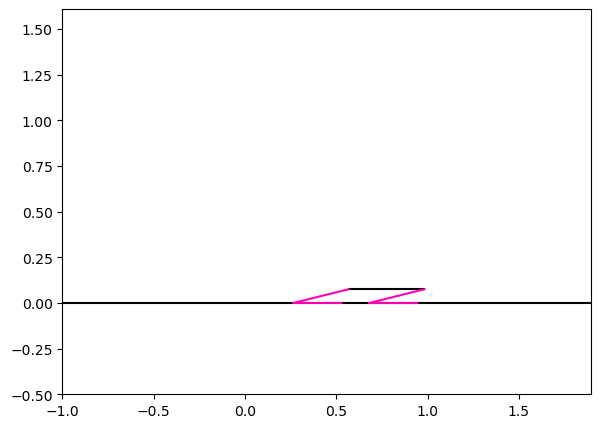

In [12]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=[10,5],dpi=100) #create axes
ax.set_aspect('equal')

xmax = np.max([m.q[n,'x','b'].value for n in range(1,N+1)])
ymax = np.max([m.q[n,'y','b'].value for n in range(1,N+1)])

def get_R2(th):
    R = np.array([[np.cos(th),-np.sin(th)],
                    [np.sin(th),np.cos(th)]])
    return R

def plot_robot(i): #update function for animation
    ax.clear()
    ax.set_xlim([-1,xmax+1])
    ax.set_ylim([-0.5,ymax+1])
    ax.plot([-1,xmax+1],[0,0],color='black')
    
    # body
    COM_b = np.array([[m.q[i,'x','b'].value],[m.q[i,'y','b'].value]])
    Rb = get_R2(m.q[i,'thb','b'].value)
    shoulder_b = COM_b + Rb@np.array([[dCOM['body']*m.len['b']],[0]])
    hip_b = COM_b + Rb@np.array([[-(1-dCOM['body'])*m.len['b']],[0]])
    ax.plot([hip_b[0],shoulder_b[0]],[hip_b[1],shoulder_b[1]],color='black')
    
    # tail
    Rt = get_R2(m.q[i,'tht','b'].value)
    tail_end = hip_b + Rt@np.array([[-m.len['t']],[0]])
    ax.plot([hip_b[0],tail_end[0]],[hip_b[1],tail_end[1]],color='xkcd:bright purple')
    
    cols = ['xkcd:bright pink','xkcd:bright blue']
    for s_i,s in enumerate(['R']):
        # upperarm
        Rf1 = get_R2(m.q[i,'thf1',s].value)
        elbow = shoulder_b + Rf1@np.array([[0],[-m.len['lf1']]])
        ax.plot([shoulder_b[0],elbow[0]],[shoulder_b[1],elbow[1]],color=cols[s_i])
        # forearm
        Rf2 = get_R2(m.q[i,'thf2',s].value)
        footf = elbow + Rf2@np.array([[0],[-m.len['lf2']]])
        ax.plot([elbow[0],footf[0]],[elbow[1],footf[1]],color=cols[s_i])
        # hip
        Rh1 = get_R2(m.q[i,'thh1',s].value)
        knee = hip_b + Rh1@np.array([[0],[-m.len['lh1']]])
        ax.plot([hip_b[0],knee[0]],[hip_b[1],knee[1]],color=cols[s_i])
        # knee
        Rh2 = get_R2(m.q[i,'thh2',s].value)
        footh = knee + Rh2@np.array([[0],[-m.len['lh2']]])
        ax.plot([knee[0],footh[0]],[knee[1],footh[1]],color=cols[s_i])
    
animate = ani.FuncAnimation(fig,plot_robot,range(1,N+1),interval = 50,repeat=True)
# new stuff
writervideo = ani.FFMpegWriter(fps=60)
animate.save('Mini_cheetah_vid.mp4', writer=writervideo)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
